# Tutorial about the Bloch Model-Based Reconstruction Tool in BART


    Author:        Nick Scholand
    Email:         scholand@tugraz.at
    Institution:   Graz University of Technology

**About the Tutorial**

This tutorial introduces the Bloch model-based reconstruction tool added with the `--bloch` flag to the `moba` tool in the [official BART repository](https://github.com/mrirecon/bart).
The `--bloch` option in `moba` can run on the CPU only, but it is highly recommended to have a GPU as for example provided by the Google Colab service.

### 0. Setup BART on Google Colab

The following section sets up BART on Google Colab. For a detailed explanation, see [**How to Run BART on Google Colaboratory**](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

Please skip this part and click [here](#main) if you want to run this notebook on your local machine with BART already installed.

If you want to use a GPU instance, please turn it on in Google Colab:

    Go to Edit → Notebook Settings
    Choose GPU from Hardware Accelerator drop-down menu


We check which GPU instance was assigned to this notebook.

In [46]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are required."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

GPU Type:
Tesla T4
Current GPU supports default CUDA-11.
No further actions are necessary.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


We download the current master branch version of BART and install its dependencies.

In [47]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

We compile BART with some settings for running it on the GPU on Google Colab.

In [48]:
%%bash

BRANCH=master

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

We set the required environment variables for BART.

In [49]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

We check the installed BART version.

In [50]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart/bart
# BART version: 
v0.7.00-583-g67a6e68


<a name='main'></a>
### Functions for Visualization

We define a function for visualization of the results.

In [51]:
import sys
import os
sys.path.insert(0, os.path.join(os.environ['TOOLBOX_PATH'], 'python'))
import cfl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
def diffplot(reco, ref, vmax=3, cmap='viridis', title="Nothing"):
    
    DIFF_SCALING = 20
    
    reco = np.abs(cfl.readcfl(reco).squeeze())
    ref = np.abs(cfl.readcfl(ref).squeeze())
    
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    
    # Reference
    
    im = ax1.imshow(ref, cmap=cmap, vmin=0, vmax=vmax)
    
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=15)
    cax.set_visible(False)
    
    ax1.set_title('Reference')
    
    # Reconstruction
    
    ax2 = fig.add_subplot(132)

    im2 = ax2.imshow(reco, cmap=cmap, vmin=0, vmax=vmax)
    
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')
    
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_label(title, fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cax.set_visible(False)
    
    ax2.set_title('Reconstruction')
    
    # Difference
    
    ax3 = fig.add_subplot(133)

    im3 = ax3.imshow(np.abs(reco-ref)*DIFF_SCALING, cmap=cmap, vmin=0, vmax=vmax)
    
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.xaxis.set_ticks_position('none')
    ax3.yaxis.set_ticks_position('none')

    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im3, cax=cax)
    cbar.set_label(title, fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    
    ax3.set_title('Difference')
    ax3.text(0.01*np.shape(reco)[0], 0.95*np.shape(reco)[0], 'x'+str(DIFF_SCALING), fontsize=20, color='white')


### Previous Tutorials

This tutorial assumes basic knowledge about BART cmdline tools. Please check out the following tutorials:
- Introduction to BART Cmdline tools: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2019)
- Simulation tool in BART: [Link to Tutorial](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2022)


### Create Dataset

The numerical dataset is created using BARTs `sim` and `phantom` tool.
Here, for its simplicity a single tube is simulated in k-space using a golden-angle sampled single-shot IR bSSFP sequence.

More complex geometries like the NIST phantom require a higher resolution to resolve the relatively smaller individual tubes. Thus, they are too computationally demanding for this simple tutorial.

In [60]:
%%bash

# Sequence Parameter
TR=0.0045 #[s]
TE=0.00225 #[s]
TRF=0.001 #[s]
REP=600
FA=45 #[deg]
BWTP=4

# Tissue Parameter
T1=0.8 # [s]
T2=0.1 # [s]

# Run simulation and save output to $DURATION variable defining the simulation time
bart sim --ODE --seq ir-bssfp,tr=$TR,te=$TE,nrep=$REP,pinv,ppl=$TE,trf=$TRF,fa=$FA,bwtp=$BWTP -1 $T1:$T1:1 -2 $T2:$T2:1 simu

# Create Golden-Angle based Trajectory
SAMPLES=30
SPOKES=1

bart traj -x $((2*SAMPLES)) -y $SPOKES -G -t $REP _traj

## Scale trajectory for 2-fold oversampling
bart scale 0.5 _traj _traj2

## The moba tool requires the time dimension to be in (5)!
bart transpose 5 10 _traj2 traj


# Simulate Spatial Components

## Create phantom based on trajectory
bart phantom -c -k -t traj comp_geom_ksp

# Combine simulated signal and spatial basis to create numerical dataset
bart fmac -s $(bart bitmask 6) comp_geom_ksp simu phantom_ksp

### Inversion Time

The inversion time is historically used by the `moba` tool to pass the time information to the underlying analytical forward operators. The Bloch model-based tool, does not require this vector. The timing information is included in the description of the simulated sequence: in the repetition time, the echo time, the number of repetitions,...

Still for compatibility to the previous versions the inversion time file TI still needs to be bassed. This will become optional in future releases of BART. For now, we create a dummy inversion time file.

In [53]:
%%bash

# Create dummy inversion time file

REP=600
bart index 5 ${REP} TI

### Reconstruction

For allow the `moba` tool to use the Bloch model operator `--bloch` is added.

The information about the applied sequence is passed with the `--seq` interface.
More details are requested with:

In [54]:
%%bash

bart moba --seq h

Usage of sub-option: --seq [bssfp],[ir-bssfp],[flash],[ir-flash],[tr=f],[te=f],[nspins=d],[pinv],[ipl=f],[isp=f],[ppl=f],[av-spokes=d],[slice-profile-spins=d],[trf=f],[fa=f],[bwtp=f],[off=f],[mom-sl=f]

Sub-options: configure sequence parameters

bssfp                   bSSFP
ir-bssfp                Inversion-Recovery bSSFP
flash                   FLASH
ir-flash                Inversion-Recovery FLASH
tr=float                Repetition time [s]
te=float                Echo time [s]
nspins=int              Number of averaged spins
pinv                    Use perfect inversions
ipl=float               Inversion Pulse Length [s]
isp=float               Inversion Spoiler Gradient Length [s]
ppl=float               Preparation Pulse Length [s]
av-spokes=              Number of averaged consecutive spokes
slice-profile-spins=    Number of spins in the slice-profile
trf=float               Pulse Duration [s]
fa=float                Flip angle [deg]
bwtp=float              Bandwidth-Time-Produ

In this example, we pass the sequence type, the repetition and echo time and many more parameter:
`ir-bssfp,tr=${TR},te=${TE},...`

The simulation type can be controlled with the `moba --sim` interface:

In [55]:
%%bash

bart moba --sim h

Usage of sub-option: --sim [ODE],[STM]

Sub-options: configure simulation parameters

ODE    full ordinary differential equation solver based simulation
STM    state-transition matrix based simulation (default)
h      help


Currently, it supports an ordinary differential equation solver (ODE) and a state-transition matrix (STM) simulation of the Bloch equations.

The flag `--img_dims $DIM:$DIM:1` defines the $k_{\text{max}}$ of the actual k-space with taking the two-fold oversampling into account.

The `moba --other` interface allows passing further parameters like the partial derivative scalings, which define the preconditioning of the reconstructed parameter maps: [$R_1$, $M_0$, $R_2$, $B_1$]. With `--other pdscale=1:1:3:0` the optimization of the $B_1$ mapping is turned off (set to 0), the algorithm optimizes for $\hat{R_2}=3\cdot R_2$ and the other parameter maps are untouched.
In praxis this preconditioning often need to be tuned for a smooth convergence of the optimization. They scaling depends on the sequence type and its individual parameters.

The iteratively regularized Gauss-Newton method and FISTA are both controlled similar to previous model-based publications by Xiaoqing Wang:

* Wang, X., Roeloffs, V., Klosowski, J., Tan, Z., Voit, D., Uecker, M. and Frahm, J. (2018), Model-based T1 mapping with sparsity constraints using single-shot inversion-recovery radial FLASH. Magn. Reson. Med, 79: 730-740. https://doi.org/10.1002/mrm.26726

*  Wang, X, Rosenzweig, S, Scholand, N, Holme, HCM, Uecker, M. Model-based reconstruction for simultaneous multi-slice T1 mapping using single-shot inversion-recovery radial FLASH. Magn Reson Med. 2020; 85: 1258– 1271. https://doi.org/10.1002/mrm.28497

* Wang, X, Tan, Z, Scholand, N, Roeloffs, V, Uecker, M. Physics-based reconstruction methods for magnetic resonance imaging. Phil Trans R Soc. 2021; A379: 20200196. https://doi.org/10.1098/rsta.2020.0196   .

we will not go into very detail here, but the passed parameters are: `-i$ITER -C$INNER_ITER -s$STEP_SIZE -B$MIN_R1 -o$OS -R$REDU_FAC -j$LAMBDA -N`.

After discussing the interface, the next cell will execute the reconstruction. Depending on your system and the GPU this step can take about a minute.

If you do not want to use a GPU, please remove the `-g` flag.

In [56]:
%%bash

OS=1
REDU_FAC=3
INNER_ITER=250
STEP_SIZE=0.95
MIN_R1=0.001
ITER=8
LAMBDA=0.0005

DIM=30
TR=0.0045 #[s]
TE=0.00225 #[s]
TRF=0.001 #[s]
REP=600
FA=45 #[deg]
BWTP=4

bart moba --bloch --sim STM --img_dims $DIM:$DIM:1 \
        --seq ir-bssfp,tr=${TR},te=${TE},ppl=${TE},fa=${FA},trf=${TRF},bwtp=${BWTP},pinv \
        --other pdscale=1:1:3:0 \
        -g \
        -i$ITER -C$INNER_ITER -s$STEP_SIZE -B$MIN_R1 -d 4 -o$OS -R$REDU_FAC -j$LAMBDA -N \
        -t traj phantom_ksp TI reco sens

nufft kernel dims: [  1  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 36000 (vs. 2196000) + 2160000
ksp : [  1  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 60  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3  60   1   1   1 600   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 1036.328463
Scaling_psf: 4.973621
FP Scale[0]=1.000000
FP Scale[1]=1.000000
FP Scale[2]=3.000000
FP Scale[3]=0.000000
[ 60  60   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
[ 60  60   1   1   1 600   1   1   1   1   1 

WARN: the upper-case options for specifying dimensions are deprecated.


The chosen debug level of `-d 4` leads to the output above. It is highly recommended for direct feedback from the reconstruction.

### Post-Processing

The output of the Bloch model-based reconstruction has the dimensions

In [57]:
%%bash

cat reco.hdr

# Dimensions
60 60 1 1 1 1 4 1 1 1 1 1 1 1 1 1 
# Command
moba --bloch --sim STM --img_dims 30:30:1 --seq ir-bssfp,tr=0.0045,te=0.00225,ppl=0.00225,fa=45,trf=0.001,bwtp=4,pinv --other pdscale=1:1:3:0 -g -i8 -C250 -s0.95 -B0.001 -d 4 -o1 -R3 -j0.0005 -N -t traj phantom_ksp TI reco sens 
# Files
 >sens >reco <TI <phantom_ksp <traj
# Creator
BART v0.7.00-583-g67a6e68


40 x 40 samples for each of the 4 parameter maps.

Currently, the two-fold oversampling is not automatically compensated. Thus, we resize the data with `bart resize -c 0 $DIM 1 $DIM ...`.

The 6th dimension includes the parameter maps $R_1$, $M_0$, $R_2$ and $B_1$. We slice them `bart slice 6 ...` and invert the relaxation maps `bart spow -- -1 ...` to get the actual parameter maps $T_1$, $T_2$ and $B_1$. Multiplying the maps with a mask `bart fmac ...` can improve the visualization.

In [58]:
%%bash

# Post-Process Reconstruction

DIM=20
T1=0.8 #[s]
T2=0.1 #[s]

# Create Reference Maps

bart phantom -c -x $DIM circ

bart scale -- $T1 circ t1ref
bart scale -- $T2 circ t2ref
bart copy circ faref


# Resize output of Reconstruction
# -> compensate for 2-fold oversampling
bart resize -c 0 $DIM 1 $DIM reco reco_crop


# Convert and Mask Reconstructed Maps

bart slice 6 0 reco_crop r1map
bart spow -- -1 r1map _t1map
bart fmac _t1map circ t1map #mask
rm _t1map.cfl _t1map.hdr

bart slice 6 2 reco_crop r2map
bart spow -- -1 r2map _t2map
bart fmac _t2map circ t2map #mask
rm _t2map.cfl _t2map.hdr

bart slice 6 3 reco_crop _famap
bart fmac _famap circ famap #mask
rm _famap.cfl _famap.hdr

Finally, the maps can be visualized.

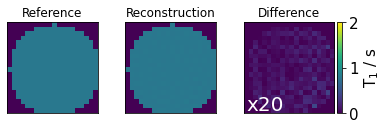

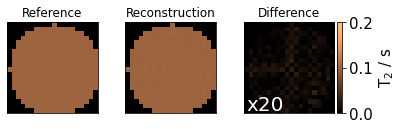

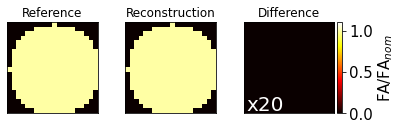

In [59]:
diffplot('t1map', 't1ref', 2, 'viridis', 'T$_1$ / s')
diffplot('t2map', 't2ref', 0.2, 'copper', 'T$_2$ / s')
diffplot('famap', 'faref', 1.1, 'hot', 'FA/FA$_{nom}$')

The difference in the relative flip angle map is zero, because the optimization was previously turned off by setting the preconditioning scaling to 0.

We can observe some small checkboard artifacts in the maps, but the overall error is small.

In [20]:
%%bash
rm *.{hdr,cfl}